# Stock Price Prediction - Data Exploration

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import config
from data.data_loader import StockDataLoader
from data.preprocessor import StockPreprocessor
from utils.visualization import StockVisualization

# Initialize visualization object
viz = StockVisualization()

plt.style.use('seaborn-v0_8')
%matplotlib inline

## Data Loading and Basic Information

In [2]:
# Load stock data
loader = StockDataLoader(symbols=config.stocks, period=config.data_period)
data = loader.get_combined_data()

print(f"Dataset shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Number of stocks: {len(data['symbol'].unique())}")
print(f"Symbols: {sorted(data['symbol'].unique())}")
print(f"\nNote: This project focuses only on CLOSE PRICE prediction")
print(f"Close price column shape: {data['close'].shape}")

Fetching data for AAPL
Fetching data for MSFT
Fetching data for GOOGL
Fetching data for TSLA
Fetching data for AMZN
Fetching data for META
Fetching data for NFLX
Fetching data for COST
Fetching data for MELI
Fetching data for SBUX
Fetching data for ABNB
Fetching data for PYPL
Fetching data for KO
Fetching data for ADBE
Fetching data for WMT
Fetching data for V
Fetching data for MCD
Fetching data for NKE
Successfully loaded data for 18 symbols
Dataset shape: (43919, 8)
Date range: 2015-08-26 00:00:00-04:00 to 2025-08-25 00:00:00-04:00
Number of stocks: 18
Symbols: ['AAPL', 'ABNB', 'ADBE', 'AMZN', 'COST', 'GOOGL', 'KO', 'MCD', 'MELI', 'META', 'MSFT', 'NFLX', 'NKE', 'PYPL', 'SBUX', 'TSLA', 'V', 'WMT']

Note: This project focuses only on CLOSE PRICE prediction
Close price column shape: (43919,)


In [4]:
# Basic statistics (focus on close price)
print("Close Price Statistics:")
close_stats = data.groupby('symbol')['close'].describe()
print(close_stats)

print(f"\nOverall Close Price Statistics:")
print(data['close'].describe())

Close Price Statistics:
         count        mean         std         min         25%         50%  \
symbol                                                                       
AAPL    2514.0  106.078646   69.519733   20.624048   40.092003  108.851978   
ABNB    1181.0  138.725737   24.647259   82.489998  120.870003  136.600006   
ADBE    2514.0  340.538282  165.175488   73.849998  205.377502  345.114990   
AMZN    2514.0  113.529112   56.246140   24.103500   71.630999  102.270000   
COST    2514.0  390.822054  259.271455  116.118286  169.656570  311.925156   
GOOGL   2514.0   91.800868   46.945980   30.944912   52.334260   75.382900   
KO      2514.0   46.614984   11.766589   27.925003   35.737744   45.145287   
MCD     2514.0  192.895000   67.381636   73.552414  136.063034  189.741707   
MELI    2514.0  922.343610  666.063174   85.258873  305.032501  825.394989   
META    2514.0  258.005615  156.807875   86.197121  151.991150  192.285103   
MSFT    2514.0  206.945080  133.124829  

In [5]:
# Check for missing values
missing_data = data.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

Missing values per column:
Series([], dtype: int64)


## Stock Price Visualization

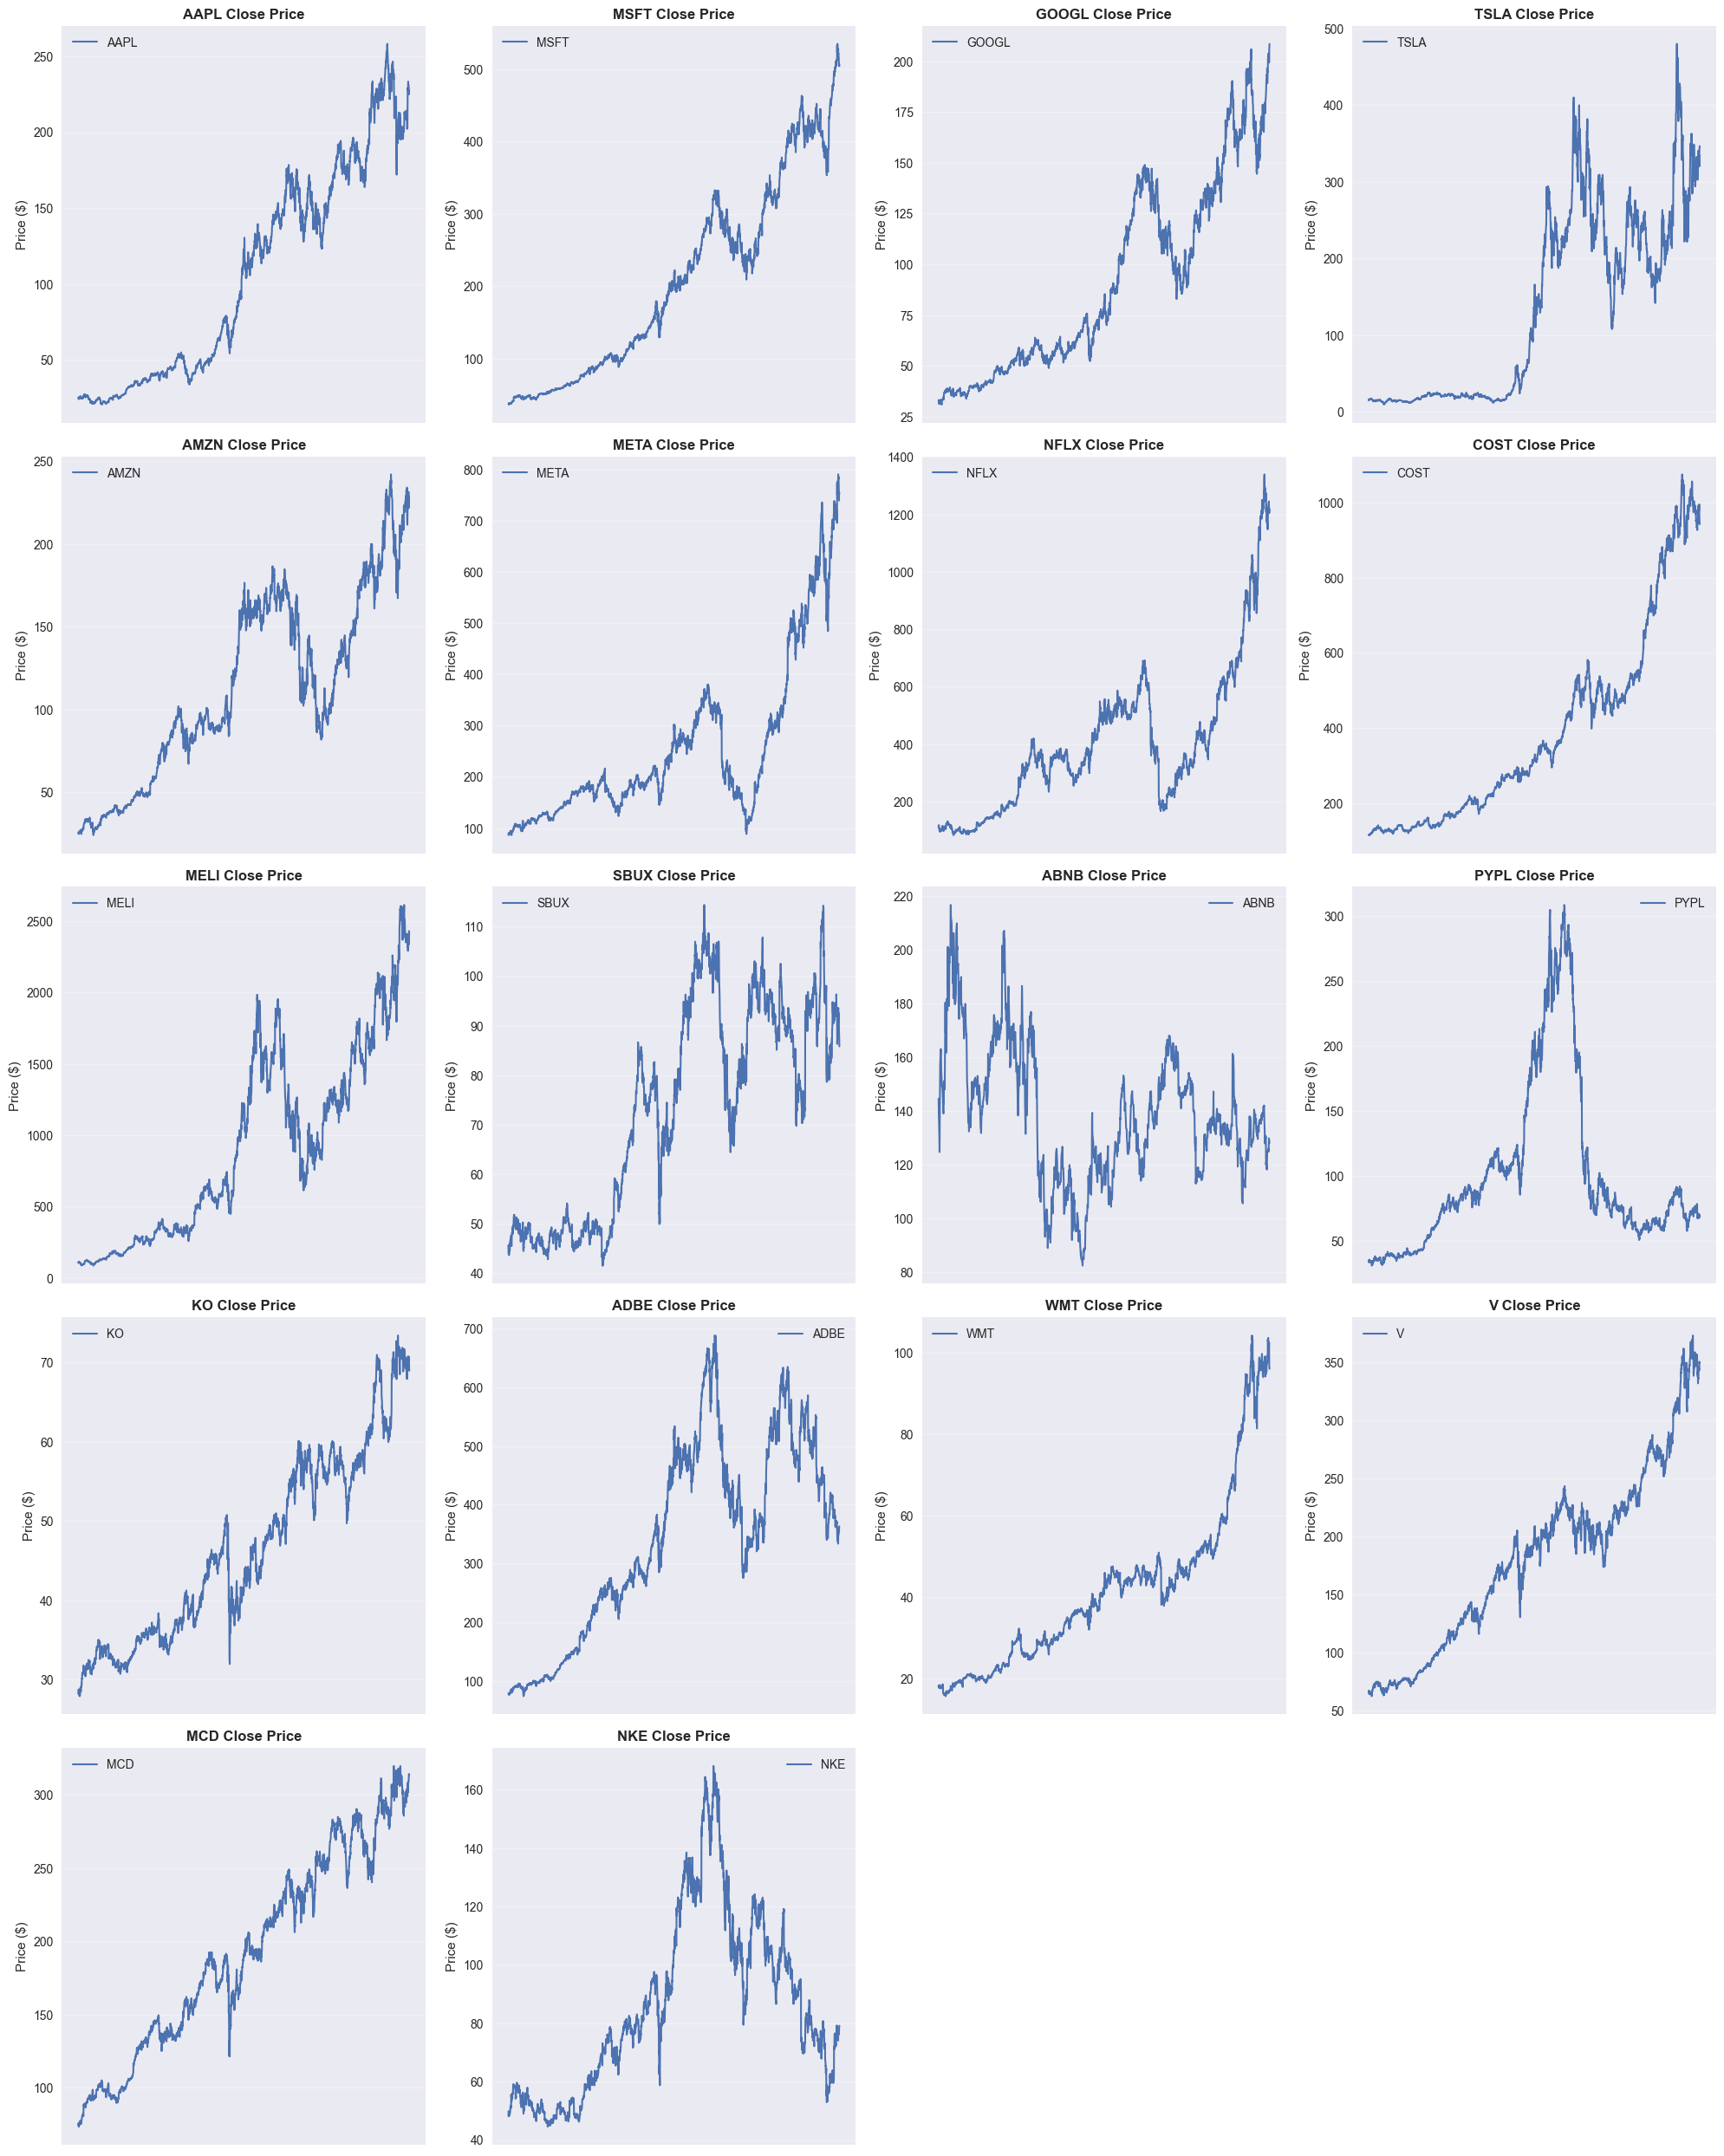

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

symbols = data['symbol'].unique()
n_stocks = len(symbols)

# Calculate grid dimensions
n_cols = 4
n_rows = (n_stocks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, symbol in enumerate(symbols):
    symbol_data = data[data["symbol"] == symbol].copy()
    
    # ✅ Use the index as datetime
    symbol_data.index = pd.to_datetime(symbol_data.index)

    axes[i].plot(
        symbol_data.index,      # <- the x-axis
        symbol_data["close"],   # <- y-axis
        linewidth=1.5,
        label=symbol
    )
    axes[i].set_title(f"{symbol} Close Price", fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Price ($)")
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend()

     # Hide x-axis
    axes[i].set_xticks([])
    axes[i].set_xlabel("")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## Scale Analysis

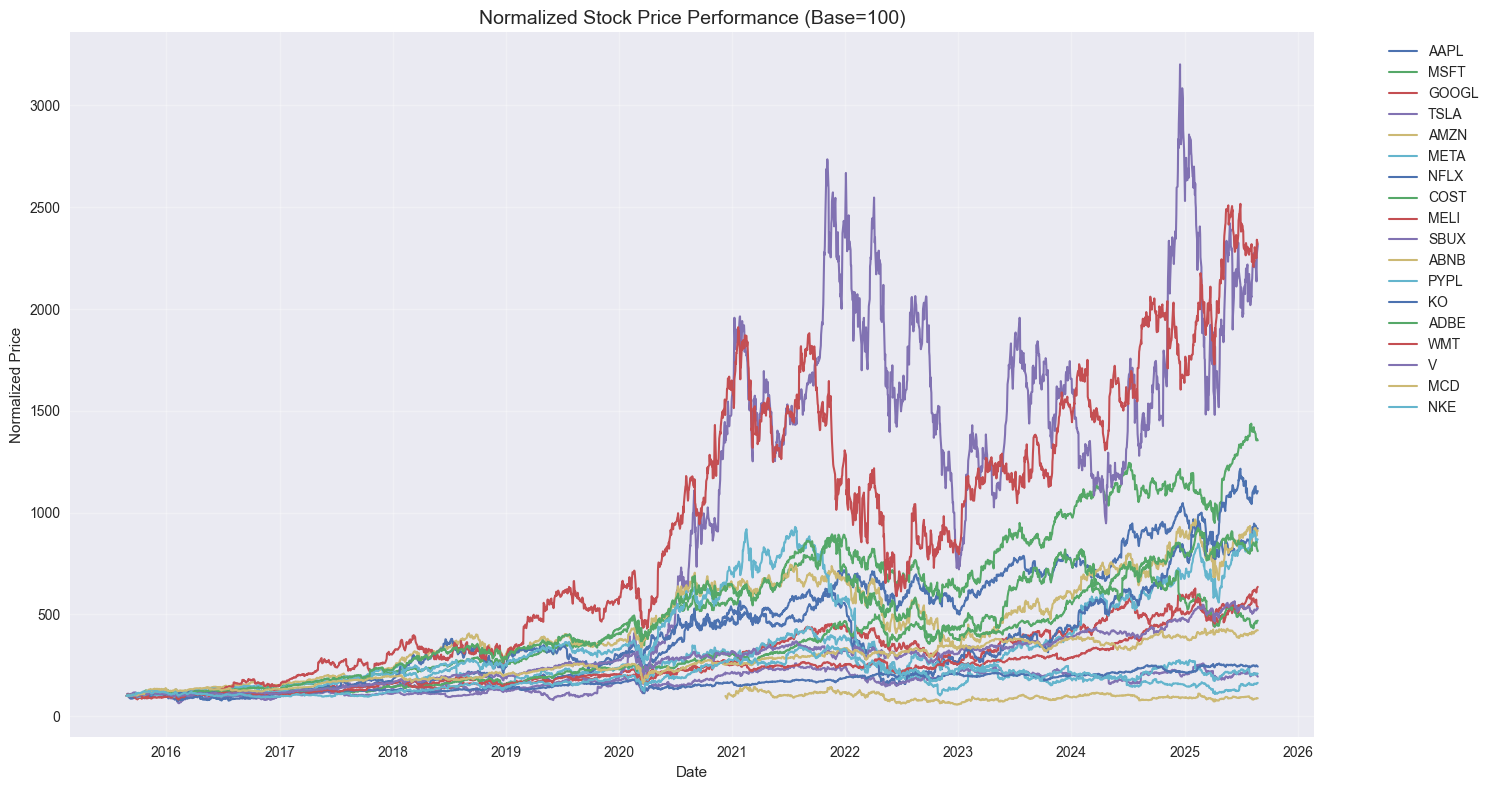

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))

# Plot normalized close prices for all stocks
for symbol in symbols:
    symbol_data = data[data["symbol"] == symbol].copy()
    symbol_data.index = pd.to_datetime(symbol_data.index)
    
    # Normalize to starting value of 100 for comparison
    normalized_prices = (symbol_data["close"] / symbol_data["close"].iloc[0]) * 100
    ax.plot(symbol_data.index, normalized_prices, label=symbol, linewidth=1.5)

ax.set_title("Normalized Stock Price Performance (Base=100)", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Price")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Data Preprocessing Pipeline

In [8]:
# Test the preprocessing pipeline with new date-based splitting
preprocessor = StockPreprocessor(sequence_length=config.sequence_length)

# Force reload data to get proper dates
import os
if os.path.exists("../data/processed/raw_stock_data.csv"):
    os.remove("../data/processed/raw_stock_data.csv")
    print("Removed old data file to force reload with dates")

# Reload with fresh data including dates
loader = StockDataLoader(symbols=config.stocks, period=config.data_period)
data = loader.get_combined_data()
print(f"Fresh data shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
if 'date' in data.columns:
    print(f"Date range: {data['date'].min()} to {data['date'].max()}")

# Prepare data with new date-based splitting
data_dict = preprocessor.prepare_data(
    data, test_size=config.test_size, validation_size=config.validation_size
)

print(f"Input features: {data_dict['input_size']}")
print(f"Training sequences: {data_dict['X_train'].shape}")
print(f"Validation sequences: {data_dict['X_val'].shape}")
print(f"Test sequences: {data_dict['X_test'].shape}")
print(f"\nFeature columns ({len(data_dict['feature_columns'])}):")
for i, feature in enumerate(data_dict["feature_columns"][:10]):
    print(f"  {i}: {feature}")

Removed old data file to force reload with dates
Fetching data for AAPL
Fetching data for MSFT
Fetching data for GOOGL
Fetching data for TSLA
Fetching data for AMZN
Fetching data for META
Fetching data for NFLX
Fetching data for COST
Fetching data for MELI
Fetching data for SBUX
Fetching data for ABNB
Fetching data for PYPL
Fetching data for KO
Fetching data for ADBE
Fetching data for WMT
Fetching data for V
Fetching data for MCD
Fetching data for NKE
Successfully loaded data for 18 symbols
Fresh data shape: (43919, 8)
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'symbol']

Using stock-aware processing with date-based splitting (no data leakage)

Date range: 2015-08-26 to 2025-08-25
Train period: 2015-08-26 to 2022-08-25
Validation period: 2022-08-25 to 2024-02-24
Test period: 2024-02-24 to 2025-08-25
Raw data split - Train: 30401, Val: 6750, Test: 6768

=== Processing Training Data (fitting scalers) ===
Processing AAPL: 1763 data points
Created 1703

## Target Distribution Analysis

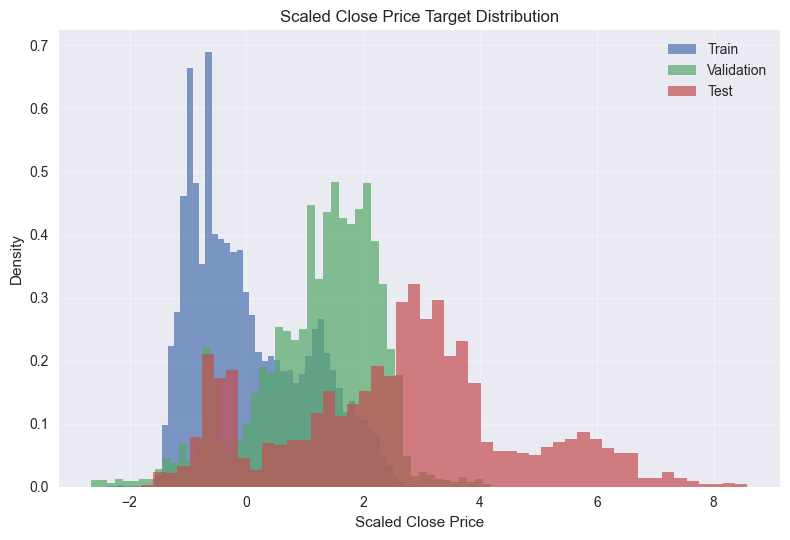

Target distribution summary:
Train: Mean=0.0391, Std=0.9916, Count=29321
Validation: Mean=1.2092, Std=1.0513, Count=5670
Test: Mean=2.6081, Std=2.0208, Count=5688


In [9]:
# Analyze target distribution (close price targets)
fig, ax = plt.subplots(1, 1)

# Original targets (scaled)
train_targets = data_dict["y_train"].flatten()
val_targets = data_dict["y_val"].flatten()
test_targets = data_dict["y_test"].flatten()

# Plot scaled distribution
ax.hist(train_targets, bins=50, alpha=0.7, label="Train", density=True)
ax.hist(val_targets, bins=50, alpha=0.7, label="Validation", density=True)
ax.hist(test_targets, bins=50, alpha=0.7, label="Test", density=True)
ax.set_title("Scaled Close Price Target Distribution")
ax.set_xlabel("Scaled Close Price")
ax.set_ylabel("Density")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot statistics comparison
stats_data = {
    'Train': train_targets,
    'Validation': val_targets,
    'Test': test_targets
}

plt.tight_layout()
plt.show()

print("Target distribution summary:")
for name, targets in stats_data.items():
    print(f"{name}: Mean={np.mean(targets):.4f}, Std={np.std(targets):.4f}, Count={len(targets)}")